In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info import Operator

from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, Latex

import pennylane as qml

# QAOA for MaxCut

In this notebook we will discuss a Quantum Approximate Optimization Algorithm *(QAOA)* for the MaxCut problem, which is combinatorial problem that cannot be computed in polynomial time, unless **P = NP**.

So let G be a graph on $n$ vertices. Given $\emptyset \neq S \subset V(G)$ we define the cut $\delta(S)$ as the set of edges connecting $S$ to its complement $\bar S$, and $\mu(G)$ denotes the size of the optimal cut for the given graph. Moreover, our focus here is to determine a cut that maximizes the number of cut edges, i.e, find the largest value for $|E(S, \bar S)|$, given that

$$
\begin{align*}
    |E(S, \bar S)| = \{(u, v)\text{ }|\text{ }u \in S, v \in \bar S\}
\end{align*}
$$


Now, let $S \subseteq V(G)$, then $x_s$ denotes the $\mathbb{Z}_2^n$-characteristic vector of $S \in \mathbb{R}^{|V(G)|}$ and $x_{\delta(S)}$ the $\mathbb{Z}_2^n$-characteristic vector of $\delta(S) \in \mathbb{R}^{E(G)}$. Then, we can write our problem as linear program given by

$$
\begin{align*}
\text{max} &\quad \frac{1}{2}\sum_{ij\text{ }\in\text{ }E(G)} w_{ij}(1 - x_i x_j)\\
\text{subject to} &\quad x_i \in \{-1, 1\}
\end{align*}
$$


Which is a very natural formulation for our Maxcut, where we also assume that the edges of the graph can be weighted.

## A Quantum Approximation Approach 

In order to quantumly encode our objective function, we will define a *Cost Hamiltonian* such that

$$
\begin{align*}
H_c|x\rangle = C(x)|x\rangle
\end{align*}
$$

Where $|x\rangle$ is a computational basis vector, which can be seen as an eigenvalue problem, defined as $T(v) = \lambda v$, where the edge $C_{ij}$ has eigenvalue 1 if and only if the $i$th and $j$th qubits have different measurements results, which represents separete partitions of our sets $S$ and $\bar S$.

And it can be written as a diagonal hamiltonian in the computational basis,

$$
\begin{align*}
H_c = \sum_{x \in\{0, 1\}^n} C(x)|x\rangle\langle x|
\end{align*}
$$

We can rewrite it expanding into Pauli-$Z$ operators, by substituting for each vector $x_i \in \{0, 1\}^n$ the matrix $x_i \rightarrow \frac{1}{2}(1 - \sigma^z_i)$, where $Z_i$ is the $Z$ operator that acts on qubit $i$. And with this assigment, we have the final equation that defines our hamiltonian in terms of the edges of the graph.

$$
\begin{align*}
H_c = \frac{1}{2}\sum_{(i, j) \in E(G)} (1 - \sigma_z^i\sigma_z^j)
\end{align*}
$$

And finally we are able to define our unitary operator that will be used in our QAOA circuit,

$$
\begin{align*}
U(H_c, \gamma) = \exp(-i\gamma H_c) = \prod^m_{\alpha = 1} e^{-i\gamma C_{\alpha}}\\
\text{          where } \gamma \in [0, 2\pi]
\end{align*}
$$

Moreover, we define our mixing Hamiltonian $H_m$ as

$$
H_m = \sum_{i = 0}^n \sigma_i^x
$$

Where $\sigma_i^x$ is the Pauli-$X$ gate acting on the $i$th qubit. And we define the $\beta$ dependent $U(H_m, \beta)$ unitary operator as it follows.

$$
\begin{align*}
U(H_m, \beta) = \exp(-i\beta H_m) = \prod^n_{\alpha = 1} e^{-i\beta X_{\alpha}}\\
\text{          where } \beta \in [0, \pi]
\end{align*}
$$

The algorithm will search for the optimal solution approximation in function of an factor $p \geq 1$, that improves the quality of our circuit. Therefore, let $|k\rangle$ be our initial uniform superpostion state on n qubits given by, 

$$
\begin{align*}
    |k\rangle &= H^{\otimes n}\underbrace{|000 \dots 0\rangle}_\text{n qubits}\\ 
              &= \frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n}|x\rangle
\end{align*}
$$

Then, using $2p$ angles parameters $\overrightarrow{\gamma}$, $\overrightarrow{\beta}$ we will define our QAOA MaxCut as a circuit that prepares the trial state $|\Psi_p(\overrightarrow{\gamma}, \overrightarrow{\beta})\rangle$, which is given by the following equation

$$
\begin{align*}
|\Psi_p(\overrightarrow{\gamma}, \overrightarrow{\beta})\rangle &= e^{-i\beta_p X_{\alpha}}e^{-i\gamma_pC_\alpha}e^{-i\beta_{p-1} X_{\alpha}}e^{-i\gamma_{p-1}C_\alpha} \dots e^{-i\beta_1 X_{\alpha}}e^{-i\gamma_{1}C_\alpha}|k\rangle\\
                              &=  U_{m_{p}} U_{c_{p}} U_{m_{p-1}} U_{c_{p-1}} \dots U_{m_{1}} U_{c_{1}}|k\rangle
\end{align*}
$$


Which can be seen as sequence of $p$ layers of unitary gates $U_m U_c$, these can be implemented as sequence of $R\sigma^z(\gamma)$, $R\sigma^x(\beta)$ and $CNOT$ gates as implemented in qiskit below

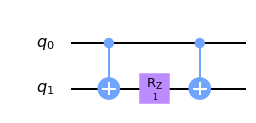

In [2]:
#Defines a circuit with 2 quantum registers
Uc = QuantumCircuit(2)

#Angle gamma
gamma = 1.0

#Edge (i, j)
i = 0; j = 1

#Unitary cost function
Uc.cx(i, j)
Uc.rz(gamma, j)
Uc.cx(i, j)

Uc.draw('mpl')

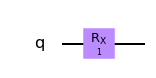

In [3]:
#Defines a circuit with 1 quantum register
Um = QuantumCircuit(1)

#Angle beta
beta = 1.0

#Vertice v
v = 0

#Unitary mixing function
Um.rx(beta, v)

Um.draw('mpl')

And our goal with this is to get a high expectation value from 

$$E_p(\overrightarrow{\gamma}, \overrightarrow{\beta}) = \langle \Psi_p(\overrightarrow{\gamma}, \overrightarrow{\beta})|H_c|\Psi_p(\overrightarrow{\gamma}, \overrightarrow{\beta})\rangle$$

Where we are interested in the max argument $M_p$, which is given by

$$
    \DeclareMathOperator*{\argmax}{arg max} % thin space, limits underneath in displays
    M_p = \argmax\limits_{\gamma, \beta} E_p(\overrightarrow{\gamma}, \overrightarrow{\beta})
$$

And we have that

$$
    \lim\limits_{p \rightarrow \infty} M_p = \max\limits_{x} C(x)
$$

Now finally, we have the material that were used to design the algorithm, which works from the following steps

$$
\begin{align*}
1.&\text{ Pick a } p \text{ and start with a set of angles that somehow make } E_p(\overrightarrow{\gamma}, \overrightarrow{\beta}) \text{ as large as possible}\\
2.&\text{ Use the Quantum Computer to get the state } |\Psi_p(\overrightarrow{\gamma}, \overrightarrow{\beta})\rangle.\\
3.&\text{ Measure in the computational basis to get a string } x \text{ and evaluate } C(x).\\
4.&\text{ Repeat with the same angles.}\\
5.&\text{ Enough repetitions will prouce a string } x \text{ with } C(x) \text{ very near
or greater than } E_p(\overrightarrow{\gamma}, \overrightarrow{\beta}).\\
\end{align*}
$$

And now the problem consists into properly choose a set of angles $(\overrightarrow{\gamma}, \overrightarrow{\beta})$. Which can be done in $O(m^2 + mn)$, by taking the angles from a grid generated by $[0, 2\pi]^p \text{ x } [0, \pi]^p$, which will efficiently produce an string $x$ that when evaluated by $C(x)$ the result is close enough or larger than $M_p$.

## Implementing with PennyLane

In [4]:
#Butterfly Graph
n_wires = 5
graph = [(0, 1), (0, 2), (1, 2), (2, 3), (2, 4), (3, 4)]

<img src="images/butterfly_graph.png" style="width:270px; height:257px"/>

In [5]:
#Mixing Hamiltonian
def U_Hm(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)

#Cost Hamiltonian
def U_Hc(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

#Computational Basis Measurement
def measurement(wires):
    return qml.Hermitian(np.diag(range(2 ** len(wires))), wires=wires)

In [6]:
backend = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

In [7]:
pauli_z = [[1, 0],
           [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

@qml.qnode(backend)
def circuit(gamma, beta, edge=None, n_layers=1):
    
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    
    for i in range(n_layers):
        U_Hc(gamma[i])
        U_Hm(beta[i])
        
    if edge is None:
        return qml.sample(measurement(range(n_wires)))
    
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

def maxcutQAOA(n_layers):
    print("\np={:d}".format(n_layers))
    
    initial_parameters = 0.01 * np.random.rand(2, 2)
    
    def objectiveFunction(angle):
        gamma = angle[0]
        beta = angle[1]
        obj = 0
        
        for edge in graph:
            obj -= 0.5 * (1 - circuit(gamma, beta, edge=edge, n_layers=n_layers))
        
        return obj
    
    opt = qml.AdagradOptimizer(stepsize=0.5)

    params = initial_parameters
    steps = 50
    
    for i in range(steps):
        params = opt.step(objectiveFunction, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objectiveFunction(params)))

    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:05b}".format(most_freq_bit_string))

    return params, bit_strings

optimized_angles_1, bitstrings1 = maxcutQAOA(1)
optimized_angles_2, bitstrings2 = maxcutQAOA(2)


p=1
Objective after step     5:  3.7729198
Objective after step    10:  3.8944360
Objective after step    15:  3.9259910
Objective after step    20:  3.9285568
Objective after step    25:  3.9287493
Objective after step    30:  3.9287634
Objective after step    35:  3.9287644
Objective after step    40:  3.9287645
Objective after step    45:  3.9287645
Objective after step    50:  3.9287645
Optimized (gamma, beta) vectors:
[[-0.58782834]
 [-1.24984905]]
Most frequently sampled bit string is: 00101

p=2
Objective after step     5:  2.9376621
Objective after step    10:  3.2673163
Objective after step    15:  3.8065555
Objective after step    20:  3.9380685
Objective after step    25:  3.9647875
Objective after step    30:  3.9715537
Objective after step    35:  3.9735012
Objective after step    40:  3.9743357
Objective after step    45:  3.9748756
Objective after step    50:  3.9753370
Optimized (gamma, beta) vectors:
[[-0.56459731  0.15304817]
 [-0.525622   -0.66243514]]
Most frequent

## Implementing with Qiskit

In [8]:
def H_c(n, i, j, gamma):
    U = QuantumCircuit(n)
    
    U.cx(i, j)
    U.rz(gamma, j)
    U.cx(i, j)
    
    U = U.to_gate()
    U.name = ' Cost '
    
    return U

def H_m(n, beta):
    U = QuantumCircuit(n)
    
    for i in range(0, n):
        U.rx(2*beta, i)
    
    U = U.to_gate()
    U.name = ' Mixing '
    
    return U

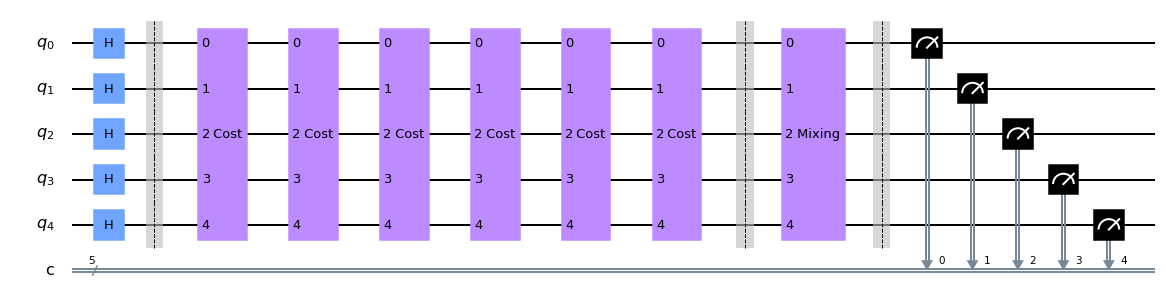

In [9]:
QAOA = QuantumCircuit(n_wires, n_wires)

gamma = optimized_angles_1[0][0]
beta = optimized_angles_1[1][0]

QAOA.h(range(n_wires))

QAOA.barrier()

for edge in graph:
    edge_i = edge[0]
    edge_j = edge[1]
    
    U_c = H_c(n_wires, edge_i, edge_j, gamma) 

    QAOA.append(U_c, range(n_wires))

QAOA.barrier()
    
U_m = H_m(n_wires, beta)
QAOA.append(U_m, range(n_wires))

QAOA.barrier()

QAOA.measure(range(n_wires), range(n_wires))

QAOA.draw('mpl')

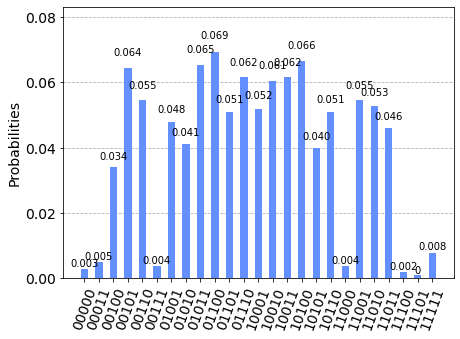

In [10]:
backend = Aer.get_backend('qasm_simulator')
result = execute(QAOA, backend).result().get_counts()
plot_histogram(result)

### References

[[1]](https://arxiv.org/pdf/1411.4028.pdf) A Quantum Approximate Optimization Algorithm, Farhi, Goldstone, and Gutmann (2014)

[[2]](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html) PennyLane QAOA for MaxCut

[[3]](https://qiskit.org/textbook/ch-applications/qaoa.html) Solving combinatorial optimization problems using QAOA